In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import random as rd
import sys

sys.path.append("..")

from AllMethods import ReversibleSymplecticNN as rs
from AllMethods import PerturbedPendulum_Methods as pp

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [9]:
d=4

file = open("X_train.txt", "r")
line_count = 0
for line in file:
    if line != "\n":
        line_count += 1
file.close()

x = []
read_x = open("X_train.txt", "r")

for i in range(int(line_count/d)):
    #8d
    #x.append([float(read_x.readline()), float(read_x.readline()), float(read_x.readline()), float(read_x.readline()), float(read_x.readline()), float(read_x.readline()), float(read_x.readline()), float(read_x.readline())])
    #4d
    x.append([float(read_x.readline()), float(read_x.readline()), float(read_x.readline()), float(read_x.readline())])

read_x.close()


y = []
read_y = open("Y_train.txt", "r")

for i in range(int(line_count/d)):
    #8d
    #y.append([float(read_y.readline()), float(read_y.readline()), float(read_y.readline()), float(read_y.readline()), float(read_y.readline()), float(read_y.readline()), float(read_y.readline()), float(read_y.readline())])
    #4d
    y.append([float(read_y.readline()), float(read_y.readline()), float(read_y.readline()), float(read_y.readline())])

read_y.close()

print("Number of points: ", len(x))
print("Number of points: ", len(y))

Number of points:  100500
Number of points:  100500


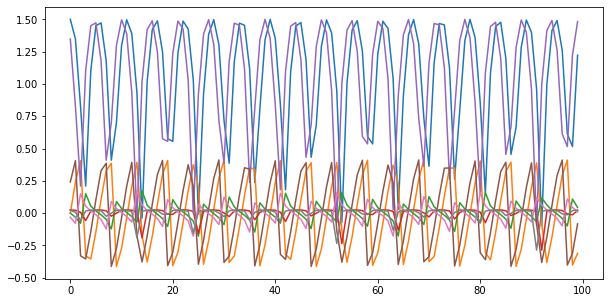

In [10]:
plt.figure(figsize=(10,5))

plt.plot(x[:100])
plt.plot(y[:100])

plt.show()

In [39]:
x_train = np.array(x)
x_train = x_train.astype(np.float32)

y_train = np.array(y)
y_train = y_train.astype(np.float32)

val_len = 10000

x_val = x_train[-val_len:]
y_val = y_train[-val_len:]

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(10000)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(60000)

In [40]:
class MLP(tf.keras.layers.Layer):
    
    def __init__(self):
        super(MLP, self).__init__()


    def build(self, input_shape):
        
        
        self.L1 = tf.keras.layers.Dense(40, activation='tanh')
        self.L2 = tf.keras.layers.Dense(40, activation='tanh')
        self.L3 = tf.keras.layers.Dense(4, activation='tanh')
        
    def call(self, inputs, training=False):
        
        h = self.L1(inputs)
        h = self.L2(h)
        h = self.L3(h)
        
        return h

In [41]:
class shift(tf.keras.layers.Layer):
    
    def __init__(self):

        super(shift, self).__init__()

    def build(self, input_shape):
        
        self.w = self.add_weight(
            name='w',
            shape=(4,),
            initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None),
            trainable = True
            )
            
        self.b = self.add_weight(
            name='b',
            shape=(4,),
            initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None),
            trainable = True
            )


    def call(self, inputs, training=False):
        
        return self.w*inputs + self.b

In [42]:
def get_shift_and_log_scale_resnet(input_shape, blocks, shift):
    
    inputs = tf.keras.Input(shape=input_shape)
    h = inputs

    for block in blocks:
        h = block(h)

    shift, log_scale = shift(inputs), h
    log_scale = tf.math.tanh(log_scale)
    return Model(inputs=inputs, outputs=[shift, log_scale], name='name')

In [43]:
class AffineCouplingLayer(tfb.Bijector):

    def __init__(self, shift_and_log_scale_fn, mask, **kwargs):
        super(AffineCouplingLayer, self).__init__(
            forward_min_event_ndims=1, **kwargs)
        self.shift_and_log_scale_fn = shift_and_log_scale_fn
        self.b = tf.cast(mask, tf.float32)

    def _forward(self, x):
        t, log_s = self.shift_and_log_scale_fn(x * self.b)
        y = self.b * x + (1 - self.b) * (x * tf.exp(log_s) + t)
        return y

    def _inverse(self, y):
        t, log_s = self.shift_and_log_scale_fn(y * self.b)
        x = self.b * y + (1 - self.b) * ((y - t) * tf.exp(-log_s))
        return x

In [ ]:
class R(tf.keras.layers.Layer):

    def __init__(self):
        super(R, self).__init__()
        
    def call(self, inputs):
    
    #8d
        #return inputs*tf.constant([[1., 1., 1., 1., -1., -1., -1., -1.]])
    #4d
        return inputs*tf.constant([[1., 1., -1., -1.]])

In [45]:
class RealNVPModel(tf.keras.Model):
    
    def __init__(self, shift_and_log_scale, **kwargs):
        
        super(RealNVPModel, self).__init__()
        self.R = R()
        masks = []
        self.l = []
        
        for j in range(len(shift_and_log_scale)):
            
            if j%4==0:
                masks.append(tf.constant([[1., 0., 1., 0.]]))
            if j%4==1:
                masks.append(tf.constant([[0., 1., 0., 1.]]))
            if j%4==2:
                masks.append(tf.constant([[1., 0., 1., 0.]]))
            if j%4==3:
                masks.append(tf.constant([[0., 1., 0., 1.]]))

        
        for i,j in zip(shift_and_log_scale, masks):
            self.l.append(AffineCouplingLayer(i, j))
        

    def call(self, input_tensor):
        
        a = self.R(input_tensor)
        
        for layer in self.l:
            a = layer._forward(a)

        a = self.R(a)

        for layer in self.l[::-1]:
            a = layer._inverse(a)
        
        return a
    

"""8d
            if j%8==0:
                masks.append(tf.constant([[0., 0., 0., 0., 1., 1., 1., 1.]]))
            if j%8==1:
                masks.append(tf.constant([[1., 0., 0., 0., 0., 1., 1., 1.]]))
            if j%8==2:
                masks.append(tf.constant([[1., 1., 0., 0., 0., 0., 1., 1.]]))
            if j%8==3:
                masks.append(tf.constant([[1., 1., 1., 0., 0., 0., 0., 1.]]))
            if j%8==4:
                masks.append(tf.constant([[1., 1., 1., 1., 0., 0., 0., 0.]]))
            if j%8==5:
                masks.append(tf.constant([[0., 1., 1., 1., 1., 0., 0., 0.]]))
            if j%8==6:
                masks.append(tf.constant([[0., 0., 1., 1., 1., 1., 0., 0.]]))
            if j%8==7:
                masks.append(tf.constant([[0., 0., 0., 1., 1., 1., 1., 0.]]))
""";

In [46]:
num_blocks = 6

blocks = [MLP() for i in range(num_blocks)]

#shifts = [shift() for i in range(len(blocks))]
shifts = [MLP() for i in range(len(blocks))]

shift_and_log_scale = [get_shift_and_log_scale_resnet((4), [i], j) for i,j in zip(blocks, shifts)]

model = RealNVPModel(shift_and_log_scale)

In [47]:
shift_and_log_scale[0].summary()
model(x_train)
model.summary()

Model: "name"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
mlp_36 (MLP)                    (None, 4)            2004        input_19[0][0]                   
__________________________________________________________________________________________________
mlp_42 (MLP)                    (None, 4)            2004        input_19[0][0]                   
__________________________________________________________________________________________________
tf.math.tanh_18 (TFOpLambda)    (None, 4)            0           mlp_36[0][0]                     
Total params: 4,008
Trainable params: 4,008
Non-trainable params: 0
___________________________

In [48]:
# DECAYING LEARNING RATE
def scheduler(epoch, lr):
    if epoch < 5:
        print(lr)
        return lr
    else:
        #print(lr)
        return lr*tf.math.exp(-0.0002)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

0.0002
0.0002
0.0002
0.0002
0.0002


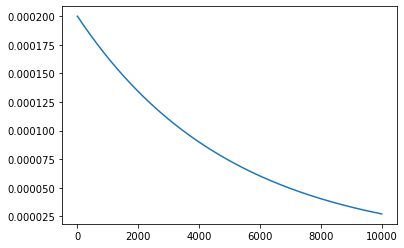

In [50]:
lr = [0.0002]
for i in range(10000):
    lr.append(scheduler(i, lr[-1]))

plt.plot(lr)
plt.show()

In [51]:
model.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    #loss = custom_loss,
    #optimizer=tfps.optimizers.bfgs_minimize(), #clipvalue = 0.001),
    #optimizer=keras.optimizers.SGD(0.00001), #, clipvalue = 0.001),
    optimizer=tf.keras.optimizers.Adam(0.002), #, clipvalue = 0.001),
    metrics=["accuracy"],
)

In [ ]:
history = model.fit(train_dataset, epochs = 1000, callbacks = [callback], verbose=1)

Epoch 1/1000
0.0020000000949949026
2/2 [==============================] - 3s 256ms/step - loss: 0.2196 - accuracy: 0.4591
Epoch 2/1000
0.0020000000949949026
2/2 [==============================] - 1s 256ms/step - loss: 0.1823 - accuracy: 0.5147
Epoch 3/1000
0.0020000000949949026
2/2 [==============================] - 1s 253ms/step - loss: 0.1300 - accuracy: 0.5058
Epoch 4/1000
0.0020000000949949026
2/2 [==============================] - 1s 252ms/step - loss: 0.1378 - accuracy: 0.4519
Epoch 5/1000
0.0020000000949949026
2/2 [==============================] - 1s 258ms/step - loss: 0.1073 - accuracy: 0.3764
Epoch 6/1000
2/2 [==============================] - 1s 265ms/step - loss: 0.0891 - accuracy: 0.5130
Epoch 7/1000
2/2 [==============================] - 1s 267ms/step - loss: 0.0781 - accuracy: 0.6625
Epoch 8/1000
2/2 [==============================] - 1s 268ms/step - loss: 0.0753 - accuracy: 0.6957
Epoch 9/1000
2/2 [==============================] - 1s 308ms/step - loss: 0.0634 - accurac

In [ ]:
model.trainable_weights

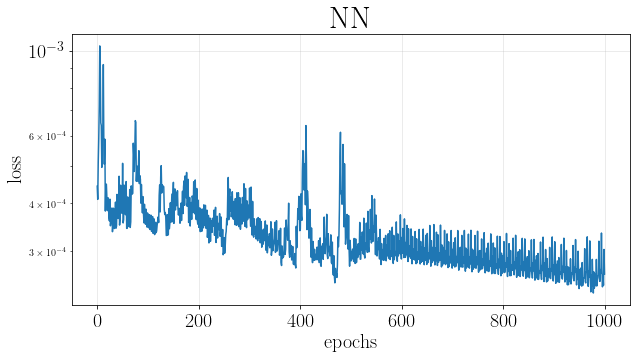

In [88]:
plt.figure(figsize = (10,5))
#plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'NN', fontsize = 30)
plt.xlabel(r'epochs', fontsize=20)
plt.ylabel(r'loss', fontsize=20)
plt.yscale("log")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
#plt.savefig("loss_Henon_E01667")

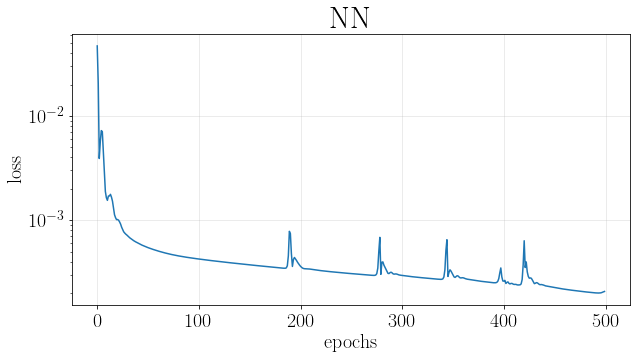

In [247]:
plt.figure(figsize = (10,5))
#plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'NN', fontsize = 30)
plt.xlabel(r'epochs', fontsize=20)
plt.ylabel(r'loss', fontsize=20)
plt.yscale("log")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
#plt.savefig("loss_Henon_E01667")

In [84]:
x0 = x_train[10]

f_iterations = [model(x0)]

In [85]:
for _ in range(3):
    f_iterations.append(model(f_iterations[-1]))

#b_iterations = [f_iterations[-1]*np.array([[-1., -1., -1.]])]

#for _ in range(100):
    #b_iterations.append(model(b_iterations[-1]))

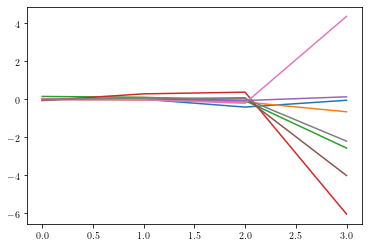

In [86]:
plt.plot([i[0].numpy() for i in f_iterations])

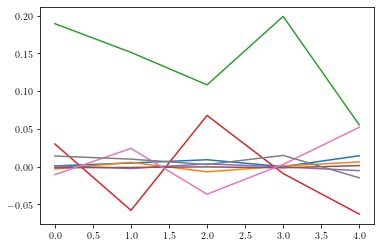

In [63]:
plt.plot(x_train[10:15])

In [124]:
y_train

array([[ 8.0828404e-04,  1.3378504e-04,  3.1356519e-04, ...,
         4.8662148e-02, -3.1356520e-03,  9.2169847e-03],
       [ 2.9731386e-03,  9.6673059e-04,  5.3282344e-04, ...,
         9.0332694e-02, -5.3282343e-03,  7.3423334e-03],
       [ 5.9478343e-03,  2.8346539e-03,  6.4043817e-04, ...,
         1.2165346e-01, -6.4043817e-03,  5.1935432e-03],
       ...,
       [ 1.5491356e-02,  1.8223394e+00, -6.0058612e-04, ...,
         1.6766056e+00,  6.0058613e-03,  4.2853114e-04],
       [ 1.2363537e-02,  1.8268144e+00, -6.4733712e-04, ...,
         1.6818560e+00,  6.4733708e-03,  1.7224055e-03],
       [ 9.0625966e-03,  1.8305620e+00, -6.6699821e-04, ...,
         1.6943799e+00,  6.6699819e-03,  3.3452539e-03]], dtype=float32)

In [84]:
model(x_train)-y_train

<tf.Tensor: shape=(400, 8), dtype=float32, numpy=
array([[-0.00055984, -0.00022432, -0.00019096, ..., -0.04120364,
         0.0033559 ,  0.00128436],
       [-0.00089648, -0.00041968, -0.00012235, ..., -0.01447354,
         0.00157259,  0.00220604],
       [-0.0009729 , -0.00105084, -0.00010581, ...,  0.00107168,
         0.0002618 ,  0.00233865],
       ...,
       [ 0.00012898, -0.00147879,  0.00055482, ...,  0.00091696,
        -0.00091054, -0.00093902],
       [ 0.00024387, -0.00187588,  0.00059383, ...,  0.000175  ,
        -0.00065751, -0.00132715],
       [ 0.00035107, -0.00211751,  0.00060735, ..., -0.00092518,
        -0.00022589, -0.00180457]], dtype=float32)>